In [8]:
import time
import os
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import grad

from torch.optim import LBFGS, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.parameter import Parameter
from tqdm import tqdm
import scipy.io


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec

torch.set_default_dtype(torch.float64)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype  = torch.float64

In [9]:
data_hi = scipy.io.loadmat('./High_fidelity/HF_data.mat')
data_lo = scipy.io.loadmat('./Low_fidelity/LF_data.mat')

x_lo    = data_lo['x'].T
h_lo    = data_lo['h'].T
K_lo    = data_lo['K'].T


x_hi    = data_hi['x'].T
h_hi    = data_hi['h'].T
K_hi    = data_hi['K'].T


# chosen high fidelity data 
vx_hi  = torch.as_tensor(np.array([x_hi[12],x_hi[23]]))
vh_hi  = torch.as_tensor(np.array([h_hi[12],h_hi[23]]))
vK_hi  = torch.as_tensor(np.array([K_hi[12],K_hi[23]]))

# chosen low fidelity data
vx_lo  = torch.as_tensor(np.array(x_lo))
vh_lo  = torch.as_tensor(np.array(h_lo))

In [10]:
def fetch_interior_data(domain,N_data):
    x_min    = domain[0]
    x_max    = domain[1]
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    x        = soboleng.draw(N_data,dtype=torch.float64)*(x_max - x_min) + x_min
    x        = x.requires_grad_(True)
    return x


def fetch_boundary_data(domain):
    x   = torch.tensor([[0.0],[200.0]])
    return x

In [11]:
class ConventBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net =nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh()) 

    def forward(self, x):
        out = self.net(x)
        return out 
    

class ModifiedResBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ModifiedResBlock, self).__init__()
        self.Ls  = None
        if in_N != out_N:
            self.Ls  = nn.Linear(in_N,out_N)
        self.net = nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh())
    def forward(self, x):
        out = self.net(x)
        if self.Ls : 
            x  = self.Ls(x)
        out = out + x
        return out 

In [12]:
class Network(torch.nn.Module):
    def __init__(self,in_N,m,H_Layer,out_N,**kwargs):
        super(Network,self).__init__()
        self.a  = nn.Parameter(torch.tensor(0.057-0.015) * torch.rand(1) + 0.015,requires_grad=True)
        self.m  = nn.Parameter(torch.tensor(0.40 -0.31 ) * torch.rand(1) + 0.31 ,requires_grad=True)
        self.Ks = torch.tensor(1.04)
    
        self.mu  = kwargs["mean"]
        self.std = kwargs["stdev"]
                 
        layers = []
        layers.append(ConventBlock(in_N,m))
        for i in range(0,H_Layer-1):
            layers.append(ConventBlock(m,m))
        layers.append(nn.Linear(m,out_N))
        # total layers
        self.net = nn.Sequential(*layers)
        

    def forward(self,x):
        # normalize the input
        data = (x - self.mu)/self.std
        out  = self.net(data)
        return out
    
    def Se(self,h):
        n  = 1/(1-self.m)
        Se = 1/(1 + torch.abs(self.a*h).pow(n)).pow(self.m)
        return Se 
    
        
    def K(self,Se):
        K = self.Ks*Se.pow(0.5)*(1 - (1 - Se.pow(1.0/self.m)).pow(self.m)).pow(2)
        return K
    
        
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)

In [13]:
def physics_loss(model,x,qe):
    h    = model(x)
    Se   = model.Se(h)
    K    = model.K(Se)
    h_x  = grad(outputs=h,inputs=x,grad_outputs = torch.ones_like(h),create_graph=True,retain_graph=True)[0]
    q    = -K*h_x
    loss = (q - qe).pow(2)
    return loss

In [14]:
def boundary_loss(model,x,ue):
    u    = model(x)
    loss = (u - ue).pow(2)
    return loss

In [17]:
kwargs ={"mean":100.0, "stdev":57.743}  
domain   = [200.0 , 0.0]
model_mf = Network(1,20,2,1,**kwargs)
model_hi = Network(1,20,2,1,**kwargs)
print(model_mf)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)
100.0


In [9]:
# exact boundary conditions 
he_b = torch.tensor([[-3.0],[-10.0]])

# exact flux 
qe   = torch.tensor(0.0122)

In [10]:
# maximum penalty value for safeguarding
mu_inf      = torch.tensor(1.0e4)

# penalty multiplication factor
eta          = torch.tensor(0.0)

epsilon      = torch.tensor(1e-8)

# generate boundary conditions 
x_b          = fetch_boundary_data(domain)

# number of epochs
epochs   = 2000

# print to dipslay epoch
disp     = 2000

#### ----------Training High Fidelity Model ----------

In [11]:
# start 10 trials 

# vector of learned parameters from high fidelity model
a_hi = []
m_hi = []

for trial in range(1,11):
    print("*"*20 + f' run({trial}) '+"*"*20)
    model_hi.apply(init_weights)
    optimizer  = torch.optim.Adam(model_hi.parameters(), lr = 1e-2) 
    # initialize penalty parameter
    mu           = torch.tensor(1.0)
    # lagrange multiplier for boundary conditions 
    Lambda_bc   = torch.zeros_like(x_b)
    # lagrange multiplier for high fidelity data 
    Lambda_hi   = torch.zeros_like(vx_hi)
    
    # starting to train high fidelity model 
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        
        # generate domain collocation points 
        x   = fetch_interior_data(domain,N_data=400)
        
        # approximate physics loss 
        pde_loss = physics_loss(model_hi,x,qe)
        
        # approximate boundary error square
        bc_ls    = boundary_loss(model_hi,x_b,he_b)
        
        # approximate total boundary loss 
        bc_loss  = (Lambda_bc*bc_ls).sum()

        # approximate high fidelity data loss 
        hi_ls   = boundary_loss(model_hi,vx_hi,vh_hi)
        hi_loss = (Lambda_hi*hi_ls).sum()
        
        # approximate penalty term 
        
        penalty = bc_ls.pow(2).sum() + hi_ls.pow(2).sum()
        
        # total loss 
        loss = pde_loss.sum() + bc_loss + hi_loss + 0.5 * mu * penalty
        
        # calculate the gradients
        loss.backward()
        
        # update the parameters
        optimizer.step()
        
        # reduce the learning rate
        #scheduler.step(loss.item())
        
        # update the multipliers 
        
        with torch.no_grad():
            if (torch.sqrt(penalty) >= 0.25*eta) and (torch.sqrt(penalty) > epsilon):
                # update penalty paramter
                mu = min(2.0*mu,mu_inf)
                
                # update boundary lagrange multipliers
                Lambda_bc   += mu * bc_ls 
                # update high fidelity lagrange multipliers
                Lambda_hi   += mu * hi_ls 
            eta  = torch.sqrt(penalty)
            if (epoch + 1% disp == 0 ):
                print(f" Epoch : {epoch}, Avg physics loss:{pde_loss.mean():2.3e}")
    # finished current trial 
    # save the learned coefficients 
    a_hi.append(np.abs(model_hi.a.detach().item()))
    m_hi.append(model_hi.m.detach().item())
    
    # display the learned parameters from the current trial 
    print(f"a : {np.abs(model_hi.a.detach().item()):2.5f}, m : {model_hi.m.detach().item():2.5f}")
    
    # save the current trained model 
    PATH  = os.getcwd()+f"/trained_models/PECANN_hi_{trial}.pt"
    torch.save(model_hi.state_dict(), PATH)

******************** run(1) ********************


100%|██████████| 2000/2000 [00:04<00:00, 480.34it/s]


a : 0.03525, m : 0.35415
******************** run(2) ********************


100%|██████████| 2000/2000 [00:04<00:00, 481.75it/s]


a : 0.03526, m : 0.35420
******************** run(3) ********************


100%|██████████| 2000/2000 [00:04<00:00, 479.75it/s]


a : 0.03490, m : 0.35244
******************** run(4) ********************


100%|██████████| 2000/2000 [00:04<00:00, 480.91it/s]


a : 0.03469, m : 0.35188
******************** run(5) ********************


100%|██████████| 2000/2000 [00:04<00:00, 477.23it/s]


a : 0.03523, m : 0.35444
******************** run(6) ********************


100%|██████████| 2000/2000 [00:04<00:00, 483.91it/s]


a : 0.03507, m : 0.35445
******************** run(7) ********************


100%|██████████| 2000/2000 [00:04<00:00, 485.01it/s]


a : 0.03410, m : 0.34931
******************** run(8) ********************


100%|██████████| 2000/2000 [00:04<00:00, 483.93it/s]


a : 0.03493, m : 0.35329
******************** run(9) ********************


100%|██████████| 2000/2000 [00:04<00:00, 479.83it/s]


a : 0.03447, m : 0.35164
******************** run(10) ********************


100%|██████████| 2000/2000 [00:04<00:00, 480.42it/s]

a : 0.03682, m : 0.36000


#### ----------- reporting the statistics of high fidelity models after 10 trials ---------------

In [12]:
print("-*-"*20)
std_a_hi,mean_a_hi= torch.std_mean(torch.abs(torch.tensor(a_hi)))
print(f"mean a: {mean_a_hi:2.4f}")
print(f"std  a: {std_a_hi:2.3e}")

print("-*-"*20)
std_m_hi,mean_m_hi= torch.std_mean(torch.tensor(m_hi))
print(f"mean m: {mean_m_hi:2.4f}")
print(f"std  m: {std_m_hi:2.3e}")

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
mean a: 0.0351
std  a: 7.181e-04
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
mean m: 0.3536
std  m: 2.783e-03


In [13]:
alpha_rel_error = 100 * abs(mean_a_hi.item() - 0.036)/0.036 
m_rel_error     = 100 * abs(mean_m_hi.item() - 0.36)/0.36 

print(f"Relative error in alpha :{alpha_rel_error: 2.3f}%")
print(f"Relative error in m : {m_rel_error :2.3f}%")

Relative error in alpha : 2.579%
Relative error in m : 1.784%


#### ----------Training Multi-Fidelity Model ----------

In [14]:
# start 10 trials 

# vector of learned parameters from high fidelity model
a_mf = []
m_mf = []

for trial in range(1,11):
    print("*"*20 + f' run({trial}) '+"*"*20)
    model_mf.apply(init_weights)
    optimizer  = torch.optim.Adam(model_mf.parameters(), lr = 1e-2) 
    scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=100,factor=0.95)
    
    # initialize penalty parameter
    mu           = torch.tensor(1.0)
    
    # lagrange multiplier for boundary conditions 
    Lambda_bc   = torch.zeros_like(x_b)
    # lagrange multiplier for high fidelity data 
    Lambda_hi   = torch.zeros_like(vx_hi)
    
    # starting to train high fidelity model 
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        
        # generate domain collocation points 
        x   = fetch_interior_data(domain,N_data=400)
        
        # approximate physics loss 
        pde_loss = physics_loss(model_mf,x,qe)
        
        # approximate boundary error square
        bc_ls    = boundary_loss(model_mf,x_b,he_b)
        
        # approximate total boundary loss 
        bc_loss  = (Lambda_bc*bc_ls).sum()

        # approximate high fidelity data loss 
        hi_ls   = boundary_loss(model_mf,vx_hi,vh_hi)
        hi_loss = (Lambda_hi*hi_ls).sum()
        
        # approximate low fidelity data loss 
        lo_loss   = boundary_loss(model_mf,vx_lo,vh_lo)
        
        # approximate penalty term 
        penalty = bc_ls.pow(2).sum() + hi_ls.pow(2).sum()
        
        # total loss 
        loss = pde_loss.sum() + lo_loss.sum() +  bc_loss + hi_loss + 0.5 * mu * penalty
        
        # calculate the gradients
        loss.backward()
        
        # update the parameters
        optimizer.step()
        
        # reduce the learning rate
        #scheduler.step(loss.item())
        
        # update the multipliers 
        
        with torch.no_grad():
            if (torch.sqrt(penalty) >= 0.25*eta) and (torch.sqrt(penalty) > epsilon):
                # update penalty paramter
                mu = min(2.0*mu,mu_inf)
                
                # update boundary lagrange multipliers
                Lambda_bc   += mu * bc_ls 
                # update high fidelity lagrange multipliers
                Lambda_hi   += mu * hi_ls 
            eta  = torch.sqrt(penalty)
            if (epoch + 1% disp == 0 ):
                print(f" Epoch : {epoch}, Avg physics loss:{pde_loss.mean():2.3e}")
                
    # finished current trial 
    # save the learned coefficients 
    a_mf.append(np.abs(model_mf.a.detach().item()))
    m_mf.append(model_mf.m.detach().item())
    
    # display the learned parameters from the current trial 
    print(f"a : {np.abs(model_mf.a.detach().item()):2.5f}, m : {model_mf.m.detach().item():2.5f}")
    
    # save the current trained model 
    PATH  = os.getcwd()+f"/trained_models/PECANN_mf_{trial}.pt"
    torch.save(model_mf.state_dict(), PATH)

******************** run(1) ********************


100%|██████████| 2000/2000 [00:04<00:00, 441.89it/s]


a : 0.03675, m : 0.35981
******************** run(2) ********************


100%|██████████| 2000/2000 [00:04<00:00, 441.22it/s]


a : 0.03545, m : 0.35600
******************** run(3) ********************


100%|██████████| 2000/2000 [00:04<00:00, 442.68it/s]


a : 0.03667, m : 0.35919
******************** run(4) ********************


100%|██████████| 2000/2000 [00:04<00:00, 422.28it/s]


a : 0.03693, m : 0.36165
******************** run(5) ********************


100%|██████████| 2000/2000 [00:04<00:00, 427.46it/s]


a : 0.03568, m : 0.35678
******************** run(6) ********************


100%|██████████| 2000/2000 [00:04<00:00, 433.61it/s]


a : 0.03523, m : 0.35522
******************** run(7) ********************


100%|██████████| 2000/2000 [00:04<00:00, 440.19it/s]


a : 0.03477, m : 0.35345
******************** run(8) ********************


100%|██████████| 2000/2000 [00:04<00:00, 419.71it/s]


a : 0.03563, m : 0.35461
******************** run(9) ********************


100%|██████████| 2000/2000 [00:04<00:00, 428.90it/s]


a : 0.03646, m : 0.35841
******************** run(10) ********************


100%|██████████| 2000/2000 [00:04<00:00, 437.66it/s]

a : 0.03533, m : 0.35399


In [15]:
print("-*-"*20)
std_a_mf,mean_a_mf= torch.std_mean(torch.abs(torch.tensor(a_mf)))
print(f"mean a: {mean_a_mf:2.4f}")
print(f"std  a: {std_a_mf:2.3e}")

print("-*-"*20)
std_m_mf,mean_m_mf= torch.std_mean(torch.tensor(m_mf))
print(f"mean m: {mean_m_mf:2.4f}")
print(f"std  m: {std_m_mf:2.3e}")

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
mean a: 0.0359
std  a: 7.511e-04
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
mean m: 0.3569
std  m: 2.744e-03


In [16]:
alpha_rel_error = 100 * abs(mean_a_mf.item() - 0.036)/0.036 
m_rel_error     = 100 * abs(mean_m_mf.item() - 0.36)/0.36 

print(f"Relative error in alpha :{alpha_rel_error: 2.3f}%")
print(f"Relative error in m : {m_rel_error :2.3f}%")

Relative error in alpha : 0.303%
Relative error in m : 0.858%


### ------- plots for paper ------- 

In [17]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((0, 0))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize' : 18, # fontsize for x and y labels
    'axes.titlesize' : 18,
    'font.size'      : 18, 
    'legend.fontsize': 16, 
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex': False,
    'figure.figsize': [3, 3],
    'font.family': 'serif',
}
plt.rcParams.update(params)

**************************************************
 Trial: 1, a:0.0368,m:0.3598,L2r_h :1.285e-02, L2r_k:1.809e-02 



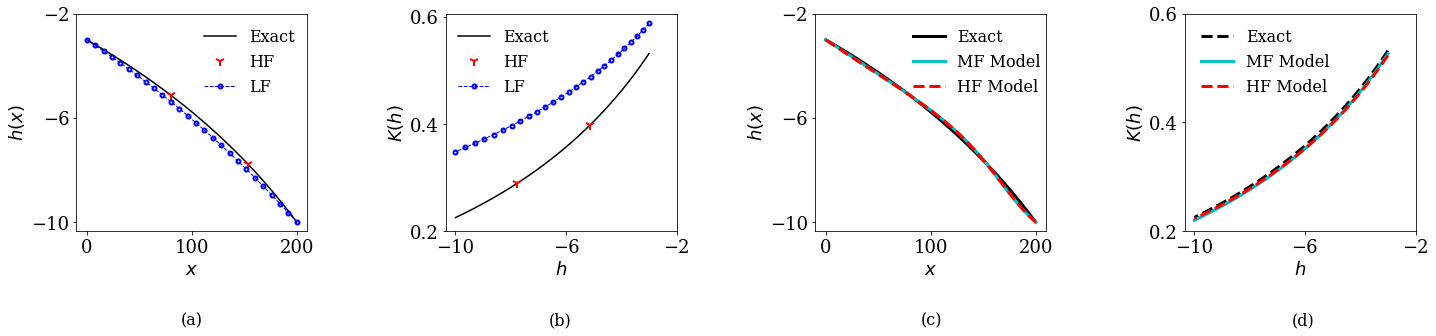

**************************************************
 Trial: 2, a:0.0355,m:0.3560,L2r_h :8.492e-03, L2r_k:1.234e-02 



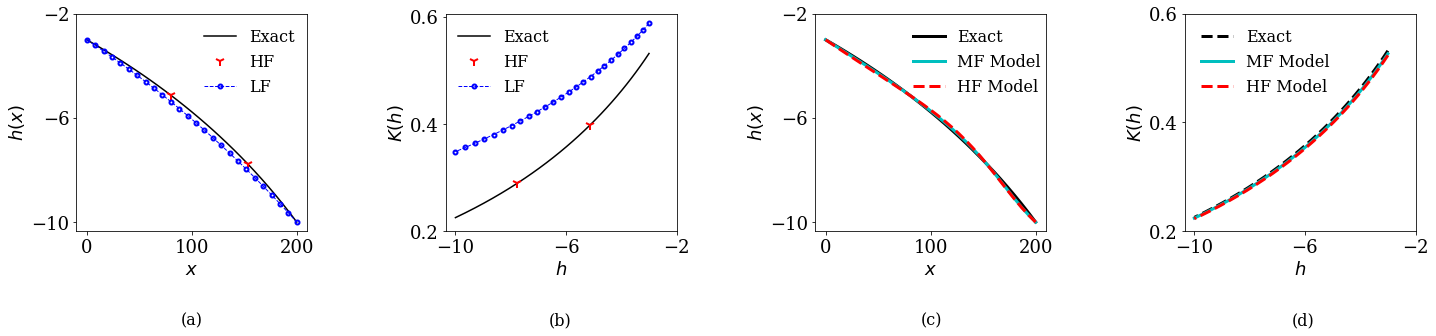

**************************************************
 Trial: 3, a:0.0367,m:0.3592,L2r_h :1.322e-02, L2r_k:1.970e-02 



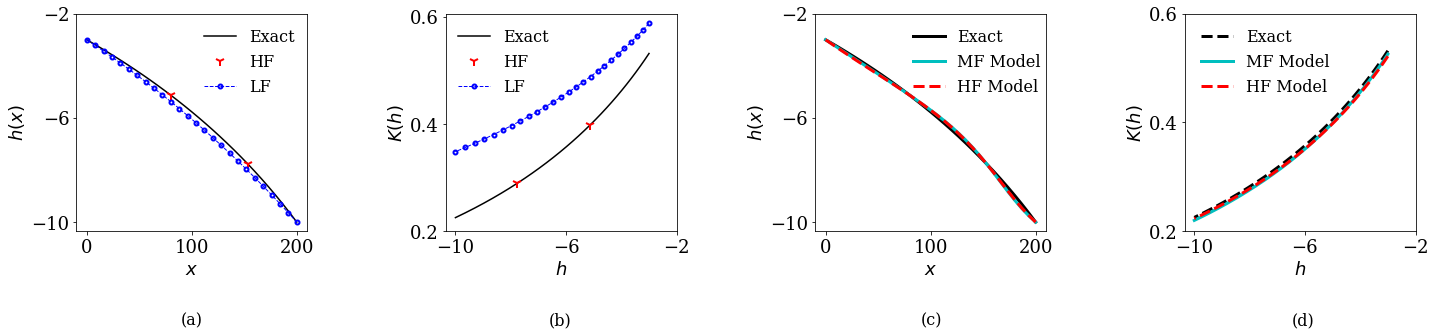

**************************************************
 Trial: 4, a:-0.0369,m:0.3616,L2r_h :9.190e-03, L2r_k:1.090e-02 



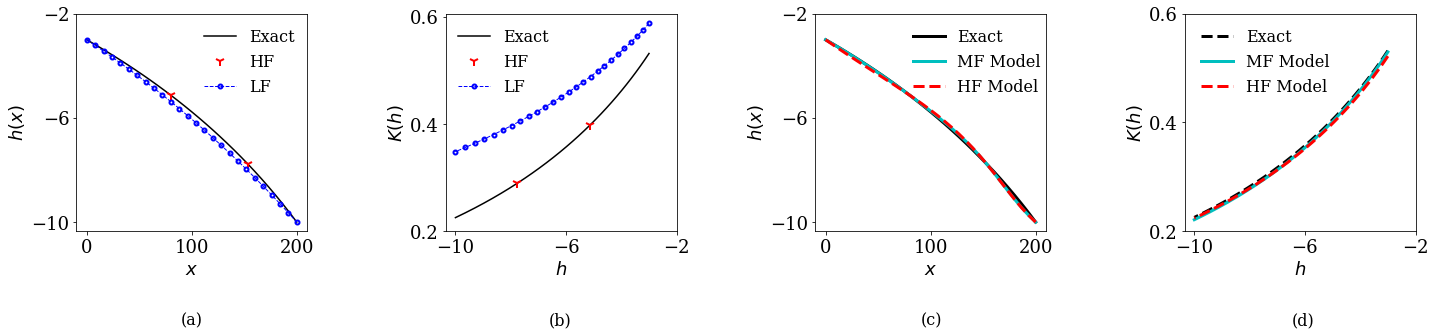

**************************************************
 Trial: 5, a:0.0357,m:0.3568,L2r_h :8.592e-03, L2r_k:1.261e-02 



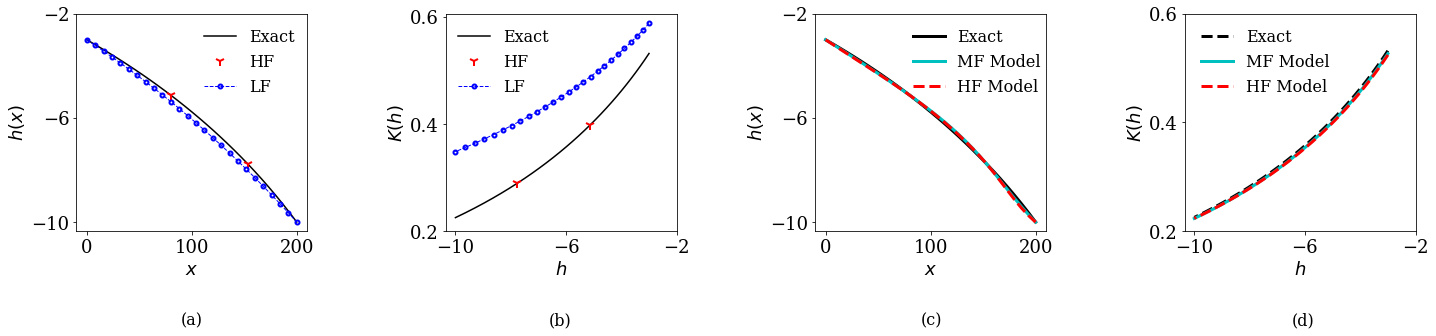

**************************************************
 Trial: 6, a:0.0352,m:0.3552,L2r_h :7.450e-03, L2r_k:1.189e-02 



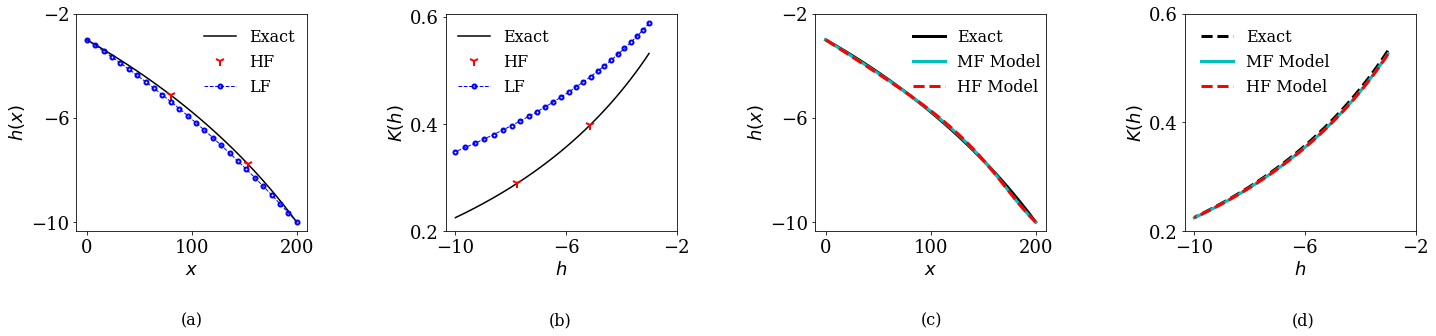

**************************************************
 Trial: 7, a:0.0348,m:0.3535,L2r_h :8.340e-03, L2r_k:1.383e-02 



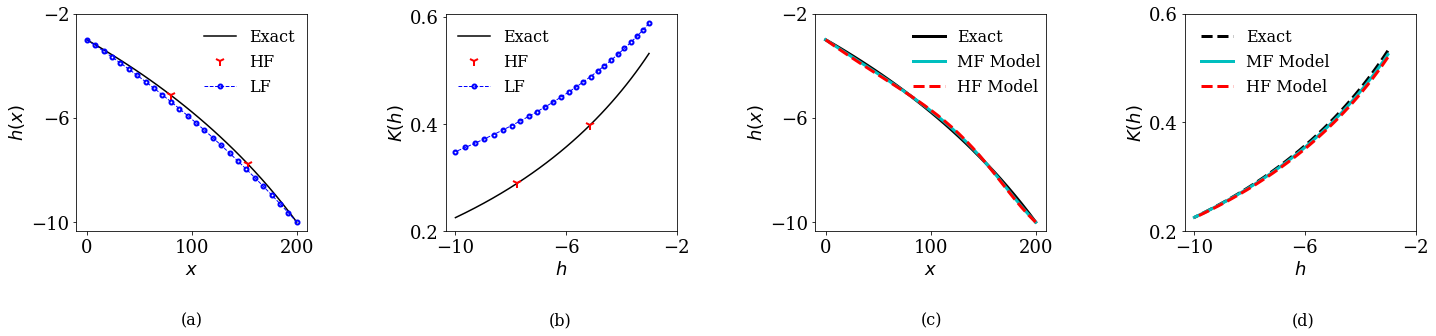

**************************************************
 Trial: 8, a:0.0356,m:0.3546,L2r_h :1.466e-02, L2r_k:2.458e-02 



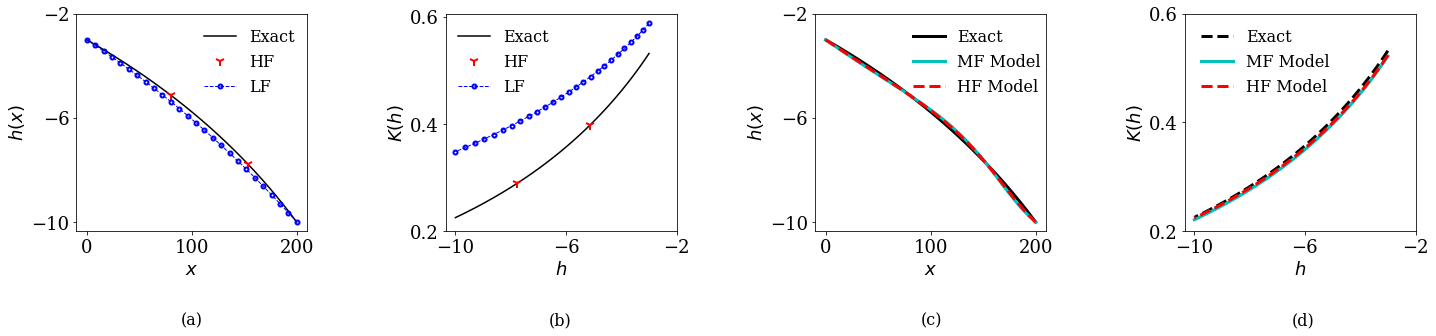

**************************************************
 Trial: 9, a:0.0365,m:0.3584,L2r_h :1.241e-02, L2r_k:1.951e-02 



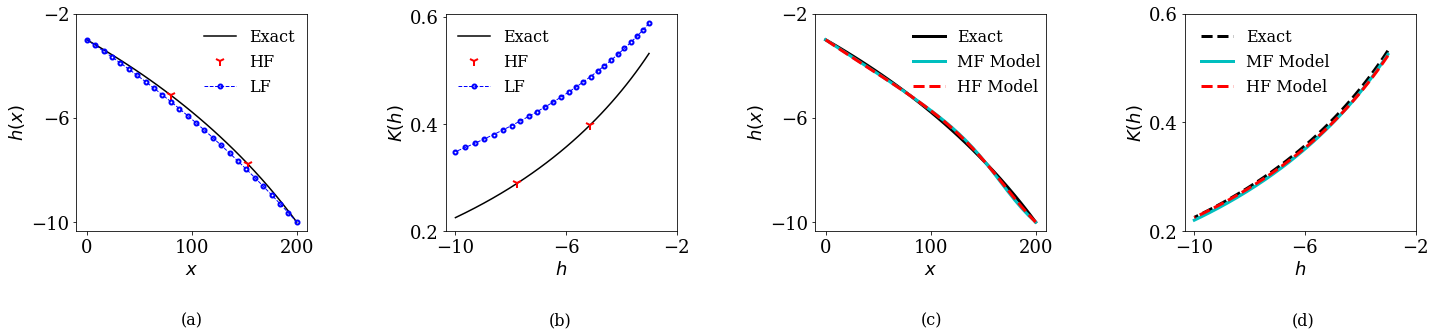

**************************************************
 Trial:10, a:0.0353,m:0.3540,L2r_h :1.330e-02, L2r_k:2.207e-02 



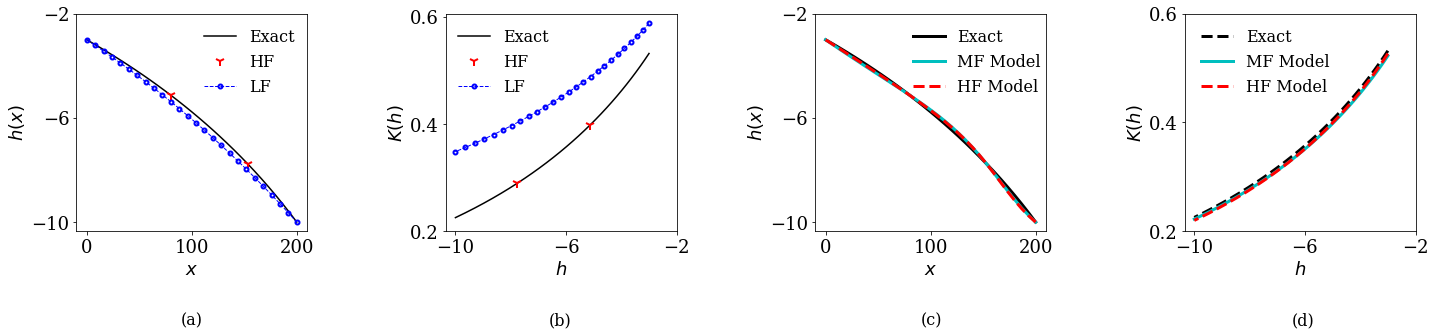

In [18]:
for trial in range(1,11):
    PATH  = os.getcwd()+f"/trained_models/PECANN_mf_{trial}.pt"
    model_mf.load_state_dict(torch.load(PATH))
    
    PATH  = os.getcwd()+f"/trained_models/PECANN_hi_{trial}.pt"
    model_hi.load_state_dict(torch.load(PATH))
    
    
    
    model_mf.eval()
    model_hi.eval()
    with torch.no_grad(): 
        print("*"*50)

        # prediction time 
        x      = torch.tensor(x_hi)
        hp_mf   = model_mf(x)
        Se_mf  = model_mf.Se(hp_mf)
        Kp_mf   = model_mf.K(Se_mf)
        
    
        hp_hi   = model_hi(x)
        Se_hi  = model_hi.Se(hp_hi)
        Kp_hi   = model_hi.K(Se_hi)
        
        L2r_h = np.linalg.norm(torch.tensor(h_hi)- hp_mf.detach(), 2)/np.linalg.norm(torch.tensor(h_hi), 2)
        L2r_k = np.linalg.norm(torch.tensor(K_hi)- Kp_mf.detach(), 2)/np.linalg.norm(torch.tensor(K_hi), 2)
        print(f" Trial:{trial:2d}, a:{model_mf.a.detach().item():2.4f},m:{model_mf.m.detach().item():2.4f},L2r_h :{L2r_h:2.3e}, L2r_k:{L2r_k:2.3e} \n")
        
    
        plt.rcParams['figure.figsize'] = (24,4)
        gs = gridspec.GridSpec(1, 4)
        gs.update(wspace=0.6)
        
        
        
        plt.figure()
        # a) high fidelity and low fidelity data 
        ax = plt.subplot(gs[0,0])
        ax.plot(x_hi,h_hi,'k-',label='Exact')
        ax.plot(vx_hi,vh_hi,'1r',mew=2,markersize=10,label='HF')
        ax.plot(vx_lo,vh_lo,'bo--',mew=2,markerfacecolor='None',markersize=4,linewidth=1,label="LF")
        ax.set_yticks([-10,-6,-2])
        ax.set_xticks([0,100,200])
        ax.set_xlabel('$x$')
        ax.set_ylabel('$h(x)$')
        ax.legend(bbox_to_anchor=(0.75, 1.),loc='upper center',ncol=1,frameon=False)
        plt.figtext(0.192,  -0.20,'(a)' ,wrap=True, horizontalalignment='center', fontsize=16)


        # b) corresponding K values for low fidelity and high fidelity data 
        ax = plt.subplot(gs[0,1])
        ax.plot(h_hi,K_hi,'k-',label='Exact')
        ax.plot(vh_hi,vK_hi,'1r',mew=2,markersize=10,label='HF')
        ax.plot(vh_lo,K_lo,'bo--',mew=2,markerfacecolor='None',markersize=4,linewidth=1,label="LF")
        ax.set_xticks([-10,-6,-2])
        ax.set_yticks([0.2,0.4,0.6])
        ax.set_xlabel('$h$')
        ax.set_ylabel('$K(h)$')
        ax.legend(bbox_to_anchor=(0.25, 1.),loc='upper center',ncol=1,frameon=False)
        plt.figtext(0.405,  -0.20,'(b)' ,wrap=True, horizontalalignment='center', fontsize=16)

        
        # c) multifidelity model prediction 
        ax = plt.subplot(gs[0,2])
        ax.plot(x_hi,h_hi,'k-',linewidth=3,label='Exact')
        ax.plot(x,hp_mf,'c-',linewidth=3,label='MF Model')
        ax.plot(x,hp_hi,'r--',linewidth=3,label='HF Model')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$h(x)$')
        ax.set_xticks([0,100,200])
        ax.set_yticks([-10,-6,-2])
        ax.legend(bbox_to_anchor=(0.70, 1),loc='upper center',ncol=1,frameon=False)
        plt.figtext(0.62,  -0.20,'(c)' ,wrap=True, horizontalalignment='center', fontsize=16)


        #d) Low and high-fidelity hydraulic conductivity
        ax = plt.subplot(gs[0,3])
        ax.plot(h_hi,K_hi,'k--',linewidth=3,label='Exact')
        ax.plot(hp_mf,Kp_mf,'c-' , linewidth=3,label='MF Model')
        ax.plot(hp_hi,Kp_hi,'r--',linewidth=3,label='HF Model')
        
        ax.set_xlabel('$h$')
        ax.set_ylabel('$K(h)$')
        ax.set_yticks([0.2,0.4,0.6])
        ax.set_xticks([-10,-6,-2])
        ax.legend(bbox_to_anchor=(0.35, 1),loc='upper center',ncol=1,frameon=False)
        plt.figtext(0.835,  -0.20,'(d)' ,wrap=True, horizontalalignment='center', fontsize=16)

        plt.show()

 Trial: 6, a:0.0352,m:0.3552,L2r_h :7.450e-03, L2r_k:1.189e-02 



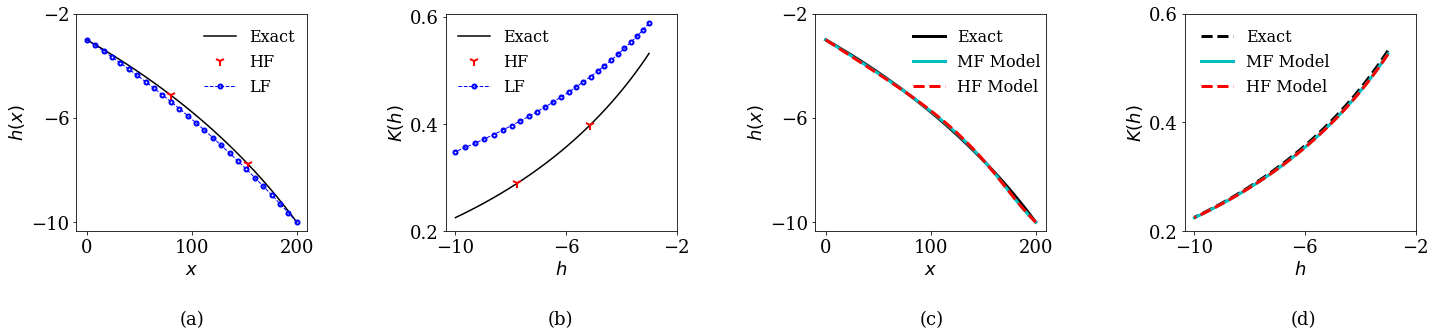

In [20]:
trial = 6
PATH  = os.getcwd()+f"/trained_models/PECANN_mf_{trial}.pt"
model_mf.load_state_dict(torch.load(PATH))

PATH  = os.getcwd()+f"/trained_models/PECANN_hi_{trial}.pt"
model_hi.load_state_dict(torch.load(PATH))



model_mf.eval()
model_hi.eval()
with torch.no_grad(): 
    # prediction time 
    x      = torch.tensor(x_hi)
    hp_mf   = model_mf(x)
    Se_mf  = model_mf.Se(hp_mf)
    Kp_mf   = model_mf.K(Se_mf)


    hp_hi   = model_hi(x)
    Se_hi  = model_hi.Se(hp_hi)
    Kp_hi   = model_hi.K(Se_hi)

    L2r_h = np.linalg.norm(torch.tensor(h_hi)- hp_mf.detach(), 2)/np.linalg.norm(torch.tensor(h_hi), 2)
    L2r_k = np.linalg.norm(torch.tensor(K_hi)- Kp_mf.detach(), 2)/np.linalg.norm(torch.tensor(K_hi), 2)
    print(f" Trial:{trial:2d}, a:{model_mf.a.detach().item():2.4f},m:{model_mf.m.detach().item():2.4f},L2r_h :{L2r_h:2.3e}, L2r_k:{L2r_k:2.3e} \n")


    plt.rcParams['figure.figsize'] = (24,4)
    gs = gridspec.GridSpec(1, 4)
    gs.update(wspace=0.6)



    plt.figure()
    # a) high fidelity and low fidelity data 
    ax = plt.subplot(gs[0,0])
    ax.plot(x_hi,h_hi,'k-',label='Exact')
    ax.plot(vx_hi,vh_hi,'1r',mew=2,markersize=10,label='HF')
    ax.plot(vx_lo,vh_lo,'bo--',mew=2,markerfacecolor='None',markersize=4,linewidth=1,label="LF")
    ax.set_yticks([-10,-6,-2])
    ax.set_xticks([0,100,200])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$h(x)$')
    ax.legend(bbox_to_anchor=(0.75, 1.),loc='upper center',ncol=1,frameon=False)
    plt.figtext(0.192,  -0.20,'(a)' ,wrap=True, horizontalalignment='center')


    # b) corresponding K values for low fidelity and high fidelity data 
    ax = plt.subplot(gs[0,1])
    ax.plot(h_hi,K_hi,'k-',label='Exact')
    ax.plot(vh_hi,vK_hi,'1r',mew=2,markersize=10,label='HF')
    ax.plot(vh_lo,K_lo,'bo--',mew=2,markerfacecolor='None',markersize=4,linewidth=1,label="LF")
    ax.set_xticks([-10,-6,-2])
    ax.set_yticks([0.2,0.4,0.6])
    ax.set_xlabel('$h$')
    ax.set_ylabel('$K(h)$')
    ax.legend(bbox_to_anchor=(0.25, 1.),loc='upper center',ncol=1,frameon=False)
    plt.figtext(0.405,  -0.20,'(b)' ,wrap=True, horizontalalignment='center')


    # c) multifidelity model prediction 
    ax = plt.subplot(gs[0,2])
    ax.plot(x_hi,h_hi,'k-',linewidth=3,label='Exact')
    ax.plot(x,hp_mf,'c-',linewidth=3,label='MF Model')
    ax.plot(x,hp_hi,'r--',linewidth=3,label='HF Model')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$h(x)$')
    ax.set_xticks([0,100,200])
    ax.set_yticks([-10,-6,-2])
    ax.legend(bbox_to_anchor=(0.70, 1),loc='upper center',ncol=1,frameon=False)
    plt.figtext(0.62,  -0.20,'(c)' ,wrap=True, horizontalalignment='center')


    #d) Low and high-fidelity hydraulic conductivity
    ax = plt.subplot(gs[0,3])
    ax.plot(h_hi,K_hi,'k--',linewidth=3,label='Exact')
    ax.plot(hp_mf,Kp_mf,'c-' , linewidth=3,label='MF Model')
    ax.plot(hp_hi,Kp_hi,'r--',linewidth=3,label='HF Model')

    ax.set_xlabel('$h$')
    ax.set_ylabel('$K(h)$')
    ax.set_yticks([0.2,0.4,0.6])
    ax.set_xticks([-10,-6,-2])
    ax.legend(bbox_to_anchor=(0.35, 1),loc='upper center',ncol=1,frameon=False)
    plt.figtext(0.835,  -0.20,'(d)' ,wrap=True, horizontalalignment='center')
plt.savefig('non_linear_soil_conductivity.png', bbox_inches='tight', pad_inches=0.02)